In [2]:
#A code to fit create averaged 13CO line measurements from MIRI data (credits for MIRI processing to, in no order, Rob Gutermuth, Mayank Narang, Himanshu Tyagi)
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
import os
import sys

from astropy import units as u
from astropy.io import fits
import pandas as pd
from spectral_cube import SpectralCube

Mini part: Note down the apertures from NIRSpec so we can convert them to MIRI WCS

In [3]:
#set up file paths
protostars = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
protostar_fullnames = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104']
source_names_list = [['IRAS 16253-2429'], ['B335W', 'B335E', 'B335 Blueshifted Knot'], ['HOPS 153SE', 'HOPS 153NW'], \
                     ['HOPS 370S', 'HOPS 370N', 'HOPS 370 Jet'], ['IRAS 20126+4104SE', 'IRAS 20126+4104NW']]
cube_file_list = [glob('MIRI/' + i + '*')[0].replace("\\", "/") for i in protostars]

#source properties
from astropy.coordinates import SkyCoord
# WCS Centers for IRAS16253:  hms_tuple(h=16.0, m=28.0, s=21.62609704541552) -24d36m24.09648651s
# WCS Centers for B335:  hms_tuple(h=19.0, m=37.0, s=0.8699079677288069) 7d34m09.39280894s
# WCS Centers for B335:  hms_tuple(h=19.0, m=37.0, s=0.9237101166280581) 7d34m09.39280909s
# WCS Centers for B335:  hms_tuple(h=19.0, m=37.0, s=1.0380396908391276) 7d34m09.49280805s
# WCS Centers for HOPS153:  hms_tuple(h=5.0, m=37.0, s=57.0367543462649) -7d06m56.22624524s
# WCS Centers for HOPS153:  hms_tuple(h=5.0, m=37.0, s=56.989725483282) -7d06m55.32624524s
# WCS Centers for HOPS370:  hms_tuple(h=5.0, m=35.0, s=27.63610108344153) -5d09m34.85369136s
# WCS Centers for HOPS370:  hms_tuple(h=5.0, m=35.0, s=27.636101076407158) -5d09m34.05369135s
# WCS Centers for HOPS370:  hms_tuple(h=5.0, m=35.0, s=27.63610107113479) -5d09m33.45369134s
# WCS Centers for IRAS20126:  hms_tuple(h=20.0, m=14.0, s=26.06792206384) 41d13m32.34371041s
# WCS Centers for IRAS20126:  hms_tuple(h=20.0, m=14.0, s=25.943827882304618) 41d13m33.54370805s

source_coords_list = [[('16h28m21.62609704541552s', '-24d36m24.09648651s')], \
                        [('19h37m0.8699079677288069s', '7d34m9.39280894s'), ('19h37m0.9237101166280581s', '7d34m9.39280909s'), ('19h37m1.0380396908391276s', '7d34m9.49280805s')], \
                        [('5h37m57.0367543462649s', '-7d6m56.22624524s'), ('5h37m56.989725483282s', '-7d6m55.32624524s')], \
                        [('5h35m27.63610108344153s', '-5d9m34.85369136s'), ('5h35m27.636101076407158s', '-5d9m34.05369135s'), ('5h35m27.63610107113479s', '-5d9m33.45369134s')], \
                        [('20h14m26.06792206384s', '41d13m32.34371041s'), ('20h14m25.943827882304618s', '41d13m33.54370805s')]]

sky_coord_list = []
for i in source_coords_list:
    dummy_list = []
    for j in i:
        dummy_list.append(SkyCoord(j[0],j[1], frame='icrs'))
    sky_coord_list.append(dummy_list)

theta = [0.0, 0.0, 50.0, 0.0, 35.0]
arc_to_pix = 3.61111097866e-05 * 3600.0 #take 1 pix in degrees from CDELT1 under the WCS parameters, convert to arcsec, then can divide by this to convert
aper_dims = [(0.51, 0.51), (0.68, 0.68), (0.53, 0.53), (0.67, 0.67), (0.49, 0.44)] #arcsecs

# Part 1: Extract averaged spectra at high SNR (no need to overplot lines yet)

In [4]:
#plotting test spectra here
from photutils.aperture import SkyRectangularAperture #, RectangularAnnulus, SkyCircularAperture
from astropy.wcs import WCS
average = 'sum' # pick median or sum for picking which one we want

#loop through, read in data files, extract data at single pixel, plot
for i in range(len(protostars)):
    for k in range(len(source_names_list[i])):
        source = source_names_list[i][k] #define name using indices

        #read in original data
        hdul = fits.open(cube_file_list[i]) #separated out line here since need to use hdul a few times
        orig_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
        # err_data = hdul['ERR'].data[1:-1, int(central_sources[i][0]), int(central_sources[i][1]) ] #needed for chi^2...converting to torch 

        #before getting a slab with an aperture, we want to use the aperture to define a mask
        rect_aper = SkyRectangularAperture(sky_coord_list[i][k], aper_dims[i][0]*u.arcsec, aper_dims[i][1]*u.arcsec, theta=theta[i]*u.deg) #using sky coords
        wcs_header = WCS(orig_cube.header).dropaxis(2) #dropping the wavelength axis in this wcs to only account for spatial transformation
        rect_mask = rect_aper.to_pixel(wcs_header).to_mask() #converting to a spatial mask

        #extracting slab
        data_list = [] #dummy list
        for data_2d in orig_cube._data[:,:,:]: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        orig_slab = np.array(data_list) #need to invoke original cutoff...but as a slab this time

        # define the wavelength grid (microns) from the header
        # wave_offset = offset_list[i] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
        # wave_factor = 1 #/1.001 #for wavelength calibrating
        # wave_units = 1 #1e6 #to convert from meters to microns, for original data just set to 1
        # wave = wave_factor * wave_units * orig_cube.spectral_axis.value #+ wave_offset
        # wave = wave[1:-1] #need to make correct axis size
        wave = orig_cube.spectral_axis.value #+ wave_offset

        #plotting to compare the bright v=1 CO lines to the weak CO lines possible in the residuals (checking for overlaps with 13CO or non-overlaps with v>1)
        #do some averages and plot
        if average == 'median':
            avg_orig_slab = np.nanmedian(orig_slab, axis=(1,2))
        elif average == 'sum':
            avg_orig_slab = np.nansum(orig_slab, axis=(1,2))

        # fig, ax = plt.subplots(figsize=(17,10)) #setup fig, axes
        # ax.plot(wave, avg_orig_slab, color='xkcd:grassy green', label='Aperture ' + average + ': ' + source) #plotting curves
        # ax.axvline(5.053115061, 0, 0.08, color='black', linestyle='--', label=r'$\rm H_2 \ S8$')
        # # ax.axvline(5.33004917, 0.5, 1, color='blue', linestyle='-', label=r'$\rm H_2 \ 1-1 \ S8$')
        # ax.axvline(5.511183183, 0, 0.08, color='blue', linestyle=':', label=r'$\rm H_2 \ S7$')
        # # ax.plot(wave, avg_total_slab, color='goldenrod', linestyle='--', label='Fit')
        # # ax.plot(wave, avg_v2_slab, color='xkcd:orange', linestyle='-.', label='Residual Fit')
        # # ax.plot(wave, orig_data - total_fit - (gas_line_V2_fit - gas_line_fit), color='xkcd:twilight blue', label='Residual (Second Fit)', alpha=0.9)
        # ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        # ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40) #need to set the xlabel here first
        # ax.legend(loc='best', fontsize=25)
        # ax.set_xlim(min(wave), 5.6)
        # # ax.set_ylim(np.min(avg_orig_slab[:750])/3, np.median(avg_orig_slab[:750])*1.5)
        # # ax.set_yscale('log')
        # ax.tick_params(axis='both', which='major', labelsize=25)
        # # fig.savefig('CO_MIRI/' + source + '_' + average + '_spectra.pdf') #save plot

    # sys.exit()

# Part 2: Subtract a baseline

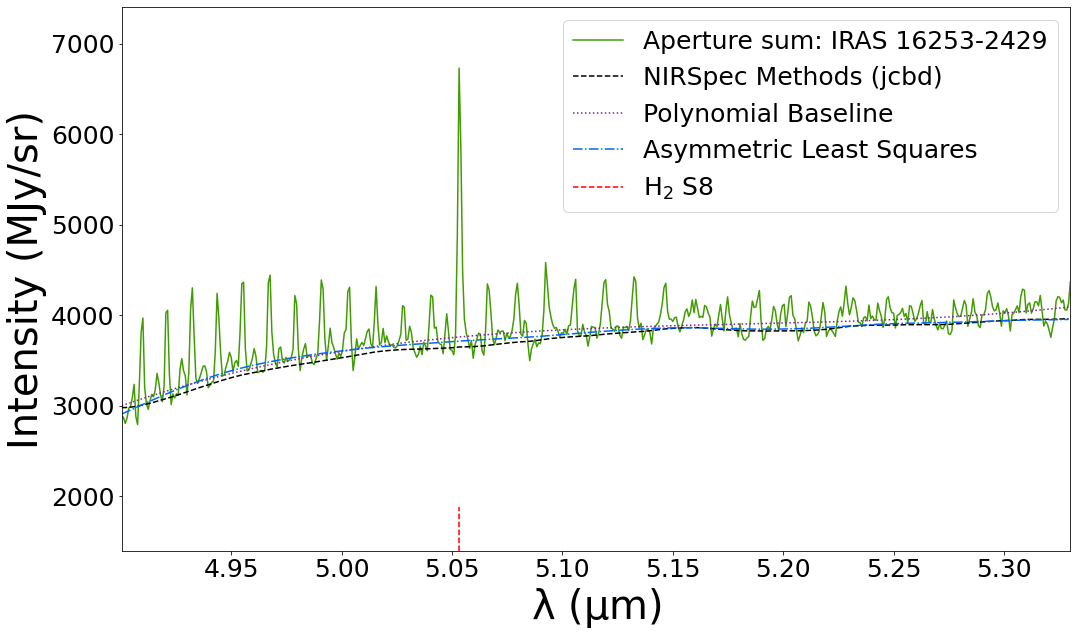

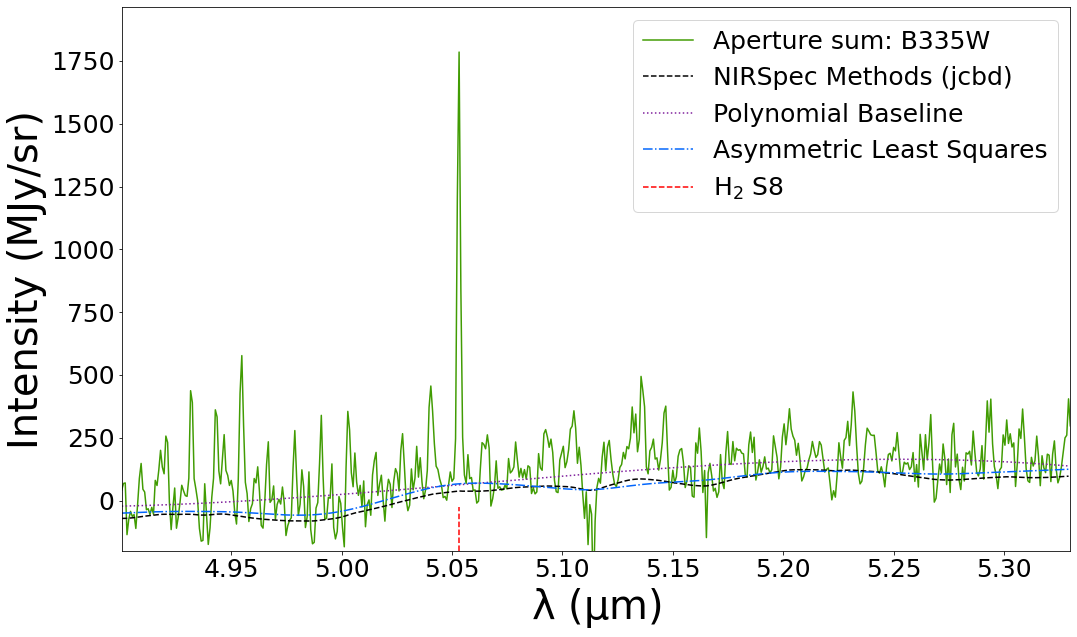

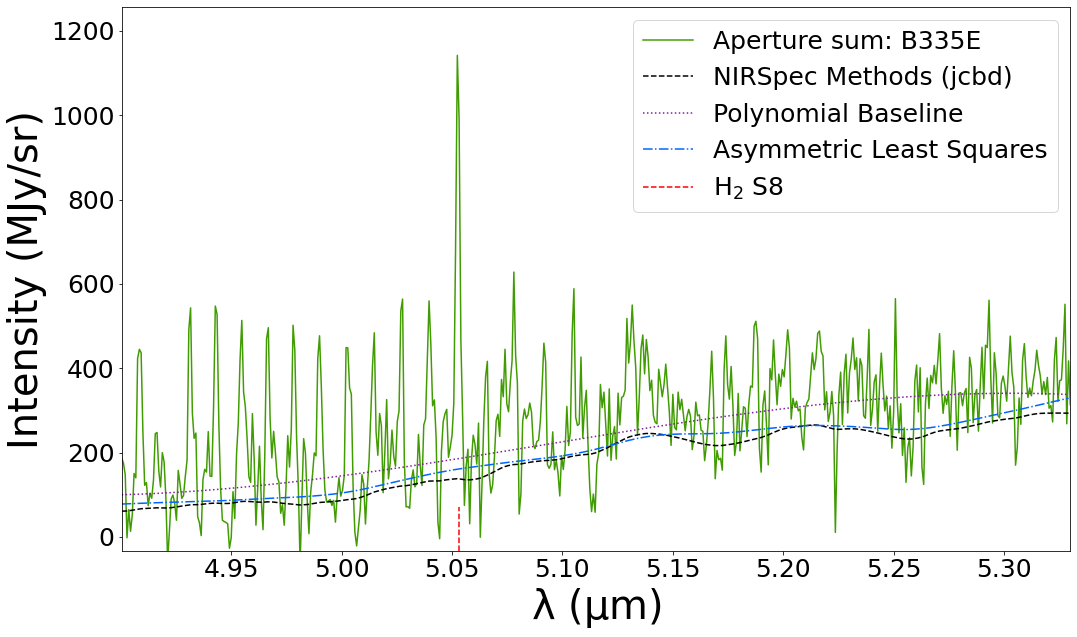

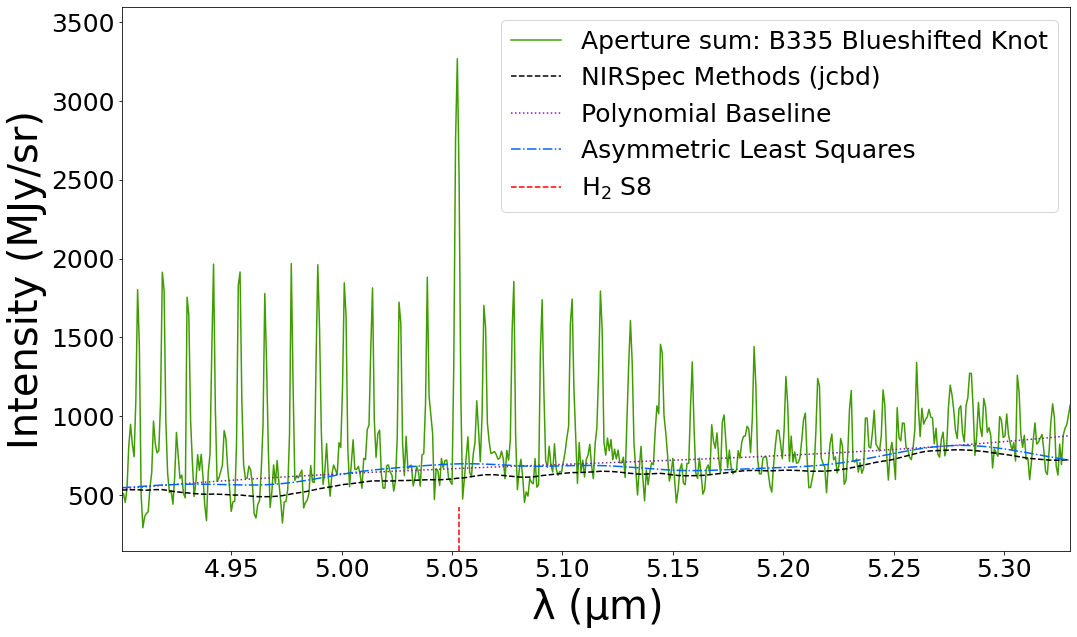

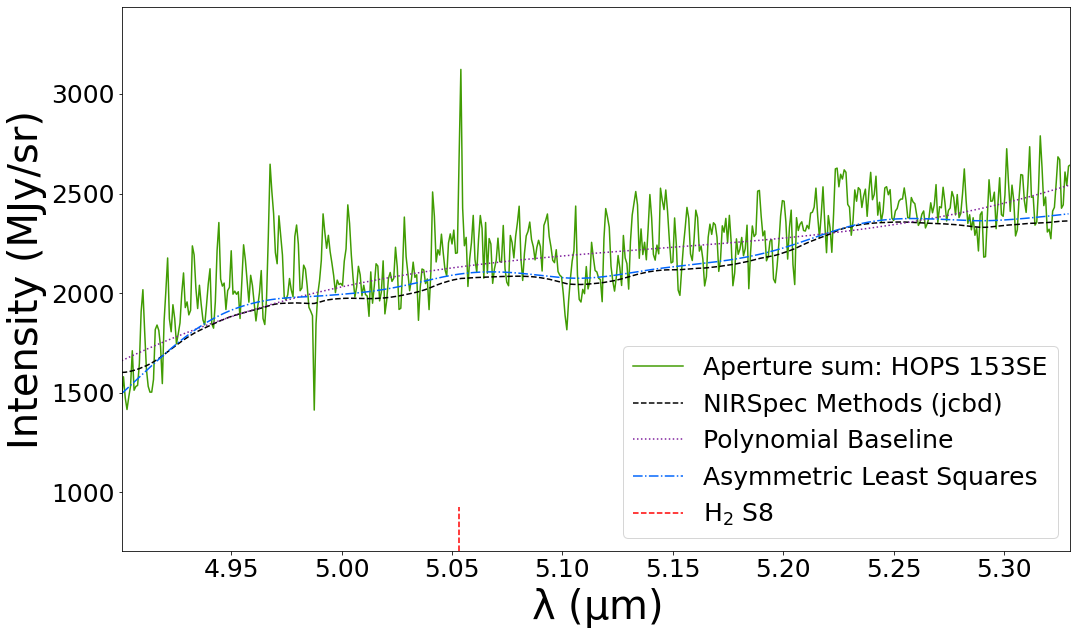

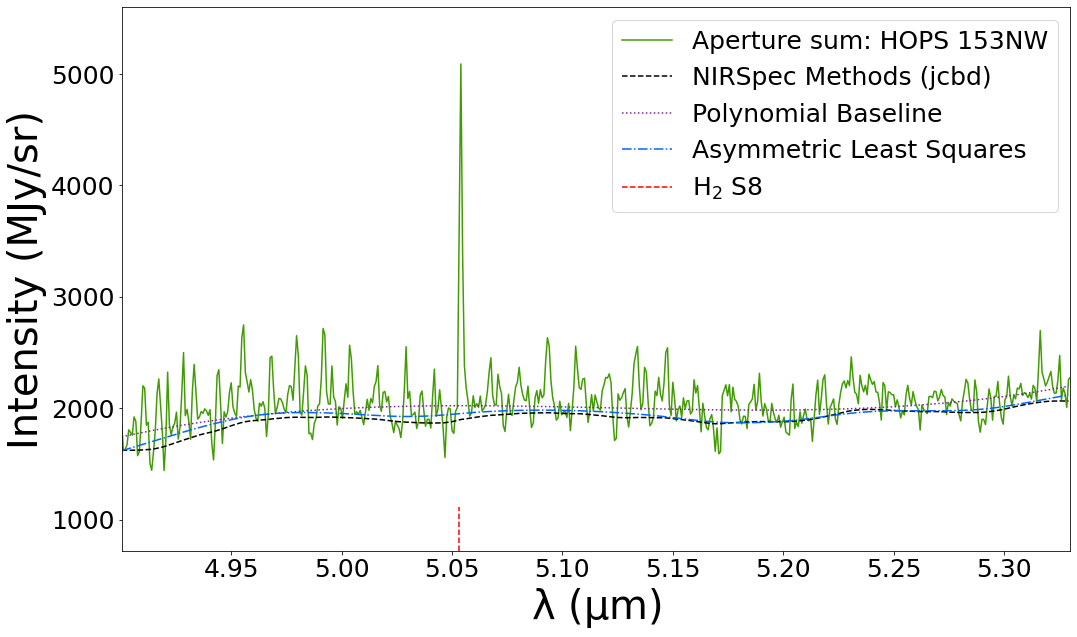

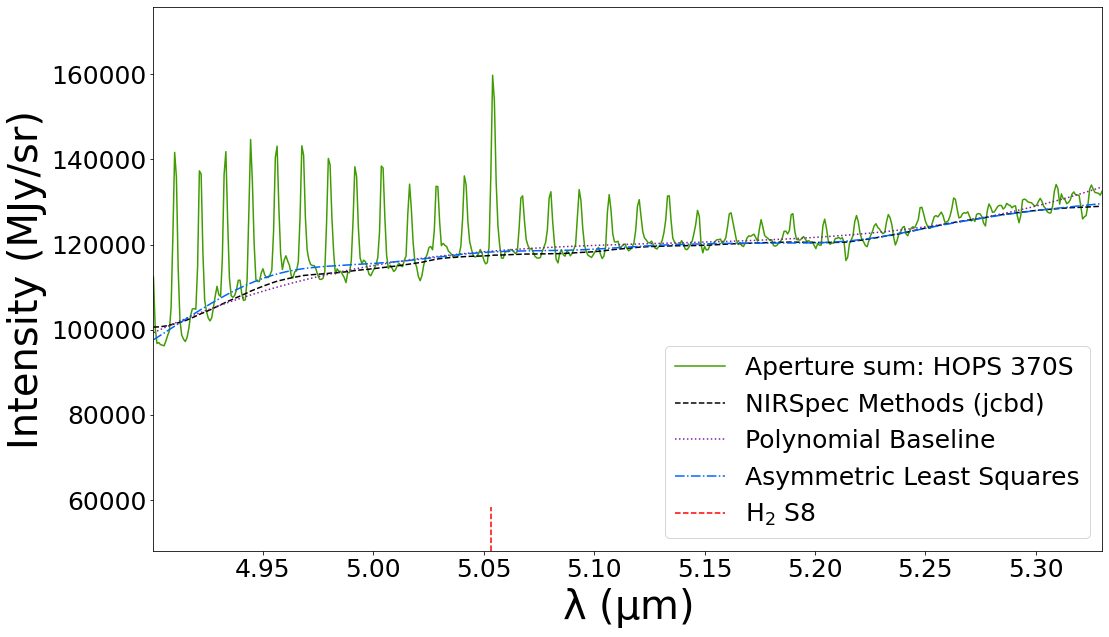

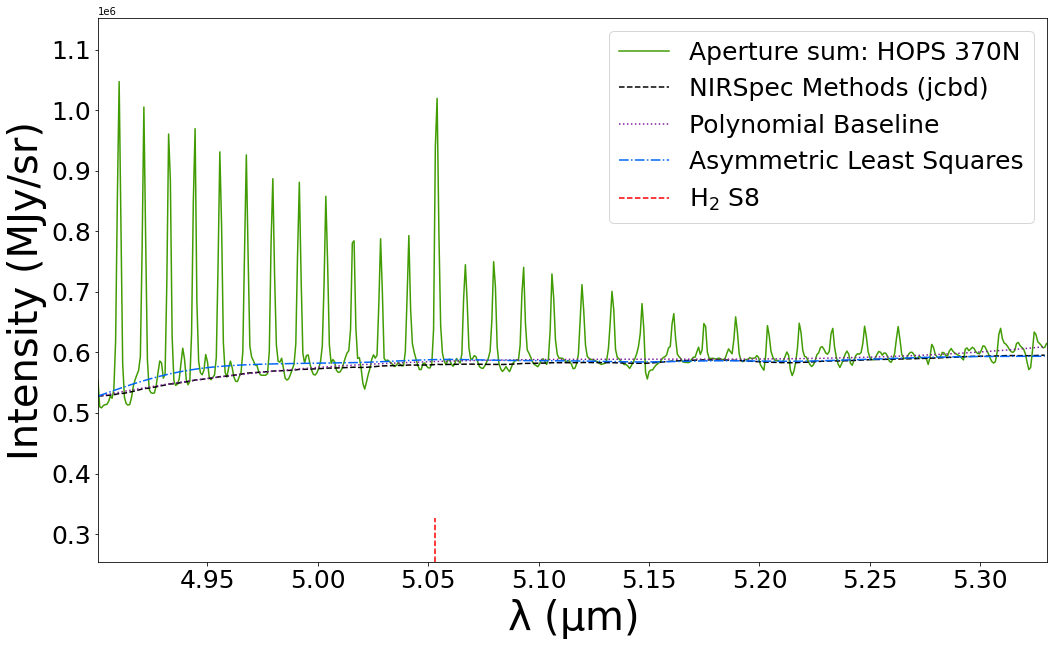

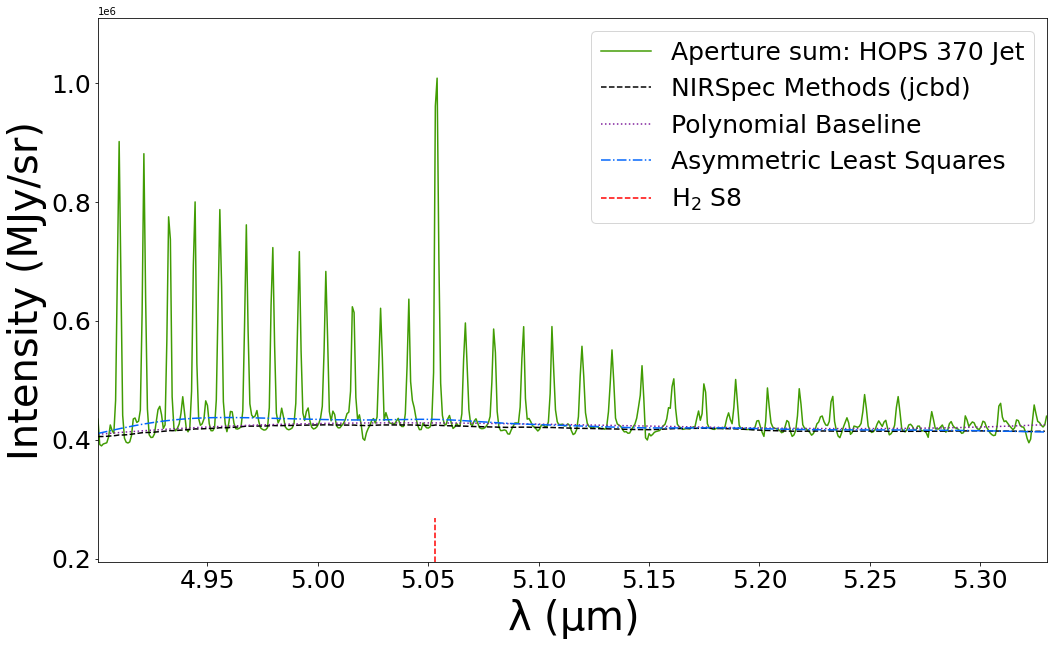

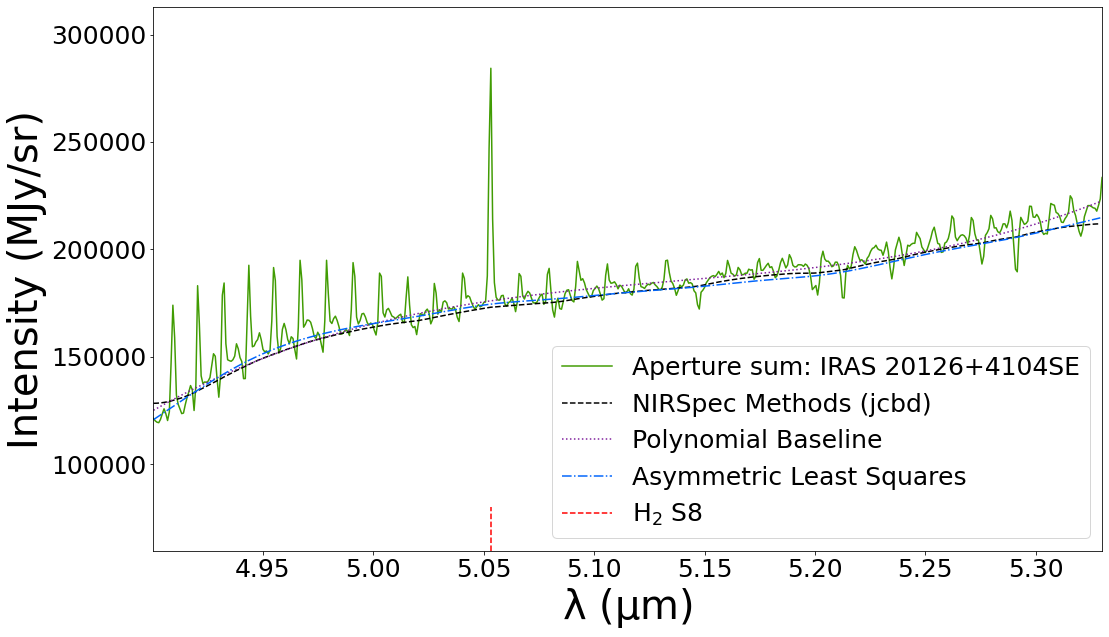

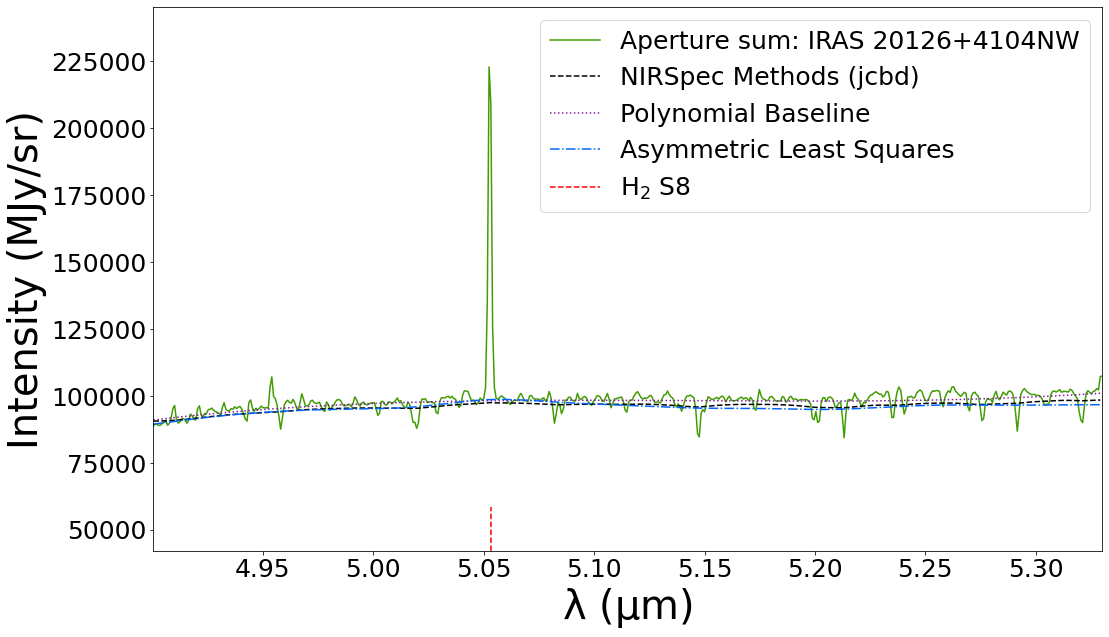

In [5]:
# Let's try making a baseline image while looping through wavelengths
from pybaselines import Baseline, utils
from scipy.signal import medfilt, savgol_filter
# from scipy.interpolate import UnivariateSpline

#params to smooth out data
# wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939])
# smooth_list = [1, 1, 10, 1, 5, 3, 10, 10] #smoothing parameters for baseline #third to last originally 3
# alpha_list = [1, 100, 50, 100, 3, 100, 1, 1] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]
# N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
wave_max_val = 5.33

#loop through, read in data files, extract data at single pixel, plot
for i in range(len(protostars)):
    for k in range(len(source_names_list[i])):
        source = source_names_list[i][k] #define name using indices

        #read in original data
        hdul = fits.open(cube_file_list[i]) #separated out line here since need to use hdul a few times
        orig_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
        # err_data = hdul['ERR'].data[1:-1, int(central_sources[i][0]), int(central_sources[i][1]) ] #needed for chi^2...converting to torch 

        #before getting a slab with an aperture, we want to use the aperture to define a mask
        rect_aper = SkyRectangularAperture(sky_coord_list[i][k], aper_dims[i][0]*u.arcsec, aper_dims[i][1]*u.arcsec, theta=theta[i]*u.deg) #using sky coords
        wcs_header = WCS(orig_cube.header).dropaxis(2) #dropping the wavelength axis in this wcs to only account for spatial transformation
        rect_mask = rect_aper.to_pixel(wcs_header).to_mask() #converting to a spatial mask

        #extracting slab
        data_list = [] #dummy list
        for data_2d in orig_cube._data[:,:,:]: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        orig_slab = np.array(data_list) #need to invoke original cutoff...but as a slab this time

        # define the wavelength grid (microns) from the header
        wave = orig_cube.spectral_axis.value #+ wave_offset
        wave_max_ind = np.argmin(np.abs(wave - wave_max_val))

        #plotting to compare the bright v=1 CO lines to the weak CO lines possible in the residuals (checking for overlaps with 13CO or non-overlaps with v>1)
        #do some averages and plot
        avg_orig_slab = np.nansum(orig_slab, axis=(1,2)) #could do median, but let's do sum

        #compute our fitted baseline of continuum+ices with a single baseline first with an initial tophat filter estimation
        # baseline_smoother = coeffs_list[-1][len(unres_wavelengths):len(unres_wavelengths)+len(smooth_list)]    
        # baseline_fitter_global = Baseline(wave[:wave_max_ind], check_finite=True) #generic preset the baseline object given a list of x-values (wavelengths)
        # bkg_top = baseline_fitter_global.tophat(avg_orig_slab[:wave_max_ind], half_window=5)[0]         #access cube to separate out an initial estimate for the baseline

        #first try, fitting with the preferred but complex method (jbcd)
        baseline_fitter_local = Baseline(wave[:wave_max_ind], check_finite=True)
        baseline = baseline_fitter_local.jbcd(avg_orig_slab[:wave_max_ind], half_window=3, alpha=0.12)[0] #this is the actual baseline fitting step
        # baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #we can also try a few other types, like polynomials and splines
        baseline_poly = baseline_fitter_local.imodpoly(avg_orig_slab[:wave_max_ind], poly_order=3)[0] #this is the actual baseline fitting step        
        baseline_alt = baseline_fitter_local.asls(avg_orig_slab[:wave_max_ind], lam=1e5, p=0.12)[0] #this is the actual baseline fitting step        

        fig, ax = plt.subplots(figsize=(17,10)) #setup fig, axes
        ax.plot(wave, avg_orig_slab, color='xkcd:grassy green', label='Aperture ' + average + ': ' + source) #plotting curves
        # ax.plot(wave[:wave_max_ind], bkg_top, color='black', linestyle='--', label='Top-Hat Filter')
        ax.plot(wave[:wave_max_ind], baseline, color='xkcd:black', linestyle='--', label='NIRSpec Methods (jcbd)')
        ax.plot(wave[:wave_max_ind], baseline_poly, color='xkcd:purple', linestyle=':', label='Polynomial Baseline')
        ax.plot(wave[:wave_max_ind], baseline_alt, color='xkcd:bright blue', linestyle='-.', label='Asymmetric Least Squares')
        ax.axvline(5.053115061, 0, 0.08, color='red', linestyle='--', label=r'$\rm H_2 \ S8$')
        # ax.axvline(5.33004917, 0.5, 1, color='blue', linestyle='-', label=r'$\rm H_2 \ 1-1 \ S8$')
        # ax.axvline(5.511183183, 0, 0.08, color='blue', linestyle=':', label=r'$\rm [Fe II]$')
        # ax.plot(wave, avg_total_slab, color='goldenrod', linestyle='--', label='Fit')
        # ax.plot(wave, avg_v2_slab, color='xkcd:orange', linestyle='-.', label='Residual Fit')
        # ax.plot(wave, orig_data - total_fit - (gas_line_V2_fit - gas_line_fit), color='xkcd:twilight blue', label='Residual (Second Fit)', alpha=0.9)
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40) #need to set the xlabel here first
        ax.legend(loc='best', fontsize=25)
        ax.set_xlim(min(wave), wave_max_val)
        ax.set_ylim(np.min(avg_orig_slab[:wave_max_ind])/2, np.max(avg_orig_slab[:wave_max_ind])*1.1)
        # ax.set_yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=25)
        # fig.savefig('CO_MIRI/' + source + '_' + average ]+ '_spectra.pdf') #save plot

        # sys.exit()

# Part 3: Fit the lines!

In [6]:
import torch

#set up your residual function for purpose of fitting
def residual_spectrum_fit(amp_unres, jwst_spectrum=torch.tensor([]), unres_exp=torch.tensor([])):
    #here, we produce a total spectrum to be fit, which takes x=wavelength as input
    #need to divide the parameters array by hand, curve_fit only takes 1d param arrays
    # amp_unres = amp_guesses[:len(unres_wavelengths)]

    '''
    trying to think in 3d
    orig cube = n x m x o, where n = m = 90 and o = 1341 (and there are 5 cubes)
    wave = 1 x 1 x o
    unres_wavelength = p, where p = 158
    amp_guesses = n x m x p
    so for p lines we want to make a sub-cube the size of amp_guesses (ices need separate handling)
    '''
    #this one takes advantage of array shaping and matrices
    # basically sum[A_ijk B_il] over i => C_ljk (formally may require writing an operator to rotate indices, but that's done implicitly here)
    unres_fit = torch.einsum('i,il->l', amp_unres.float(), unres_exp.float()).float()

    return ((jwst_spectrum).float() - unres_fit.float()).float()  #depending on your other function, need to do *params

In [7]:
#first we read in some line lists...
import pandas as pd
import itertools, re

#reformat and compute ions (aka atomic lines), again, non-simultaneous
line_list_path = 'Line list 2.1 for python.xlsx' #first, note formatting properties from excel file, order: continuum, ices, ions, hydrogen, CO
unres_line_sheets = [3]
# skiprow_list = [None, range(66, 526), range(117, 286)] #IMPORTANT: likely need to modify by hand: range(213, 286) for CO is 3-2; 117 to 213 is 2-1

#pre-calculating some values that are helpful
#taken from https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-dispersers-and-filters
# R_factor = 3.0
# jwst_res_spline = UnivariateSpline(data['WAVELENGTH'], data['R']*R_factor)
def jwst_res_dmw(line_lambda):
    return 3320+(line_lambda-4.9)*(3710+3320)/(5.74 - 4.9) #the denominator is in delta_microns

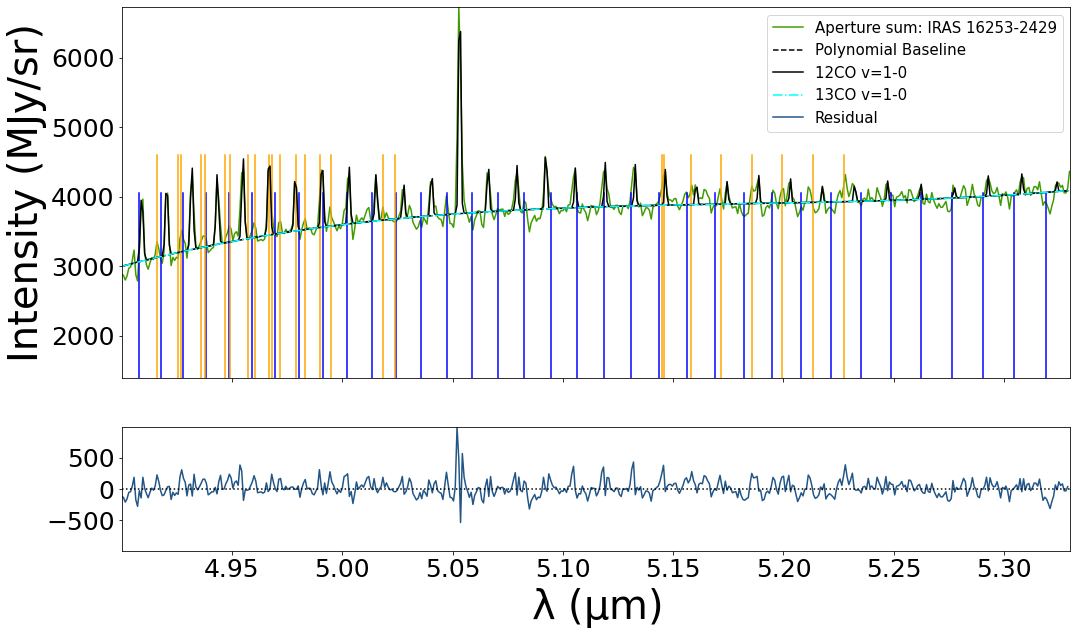

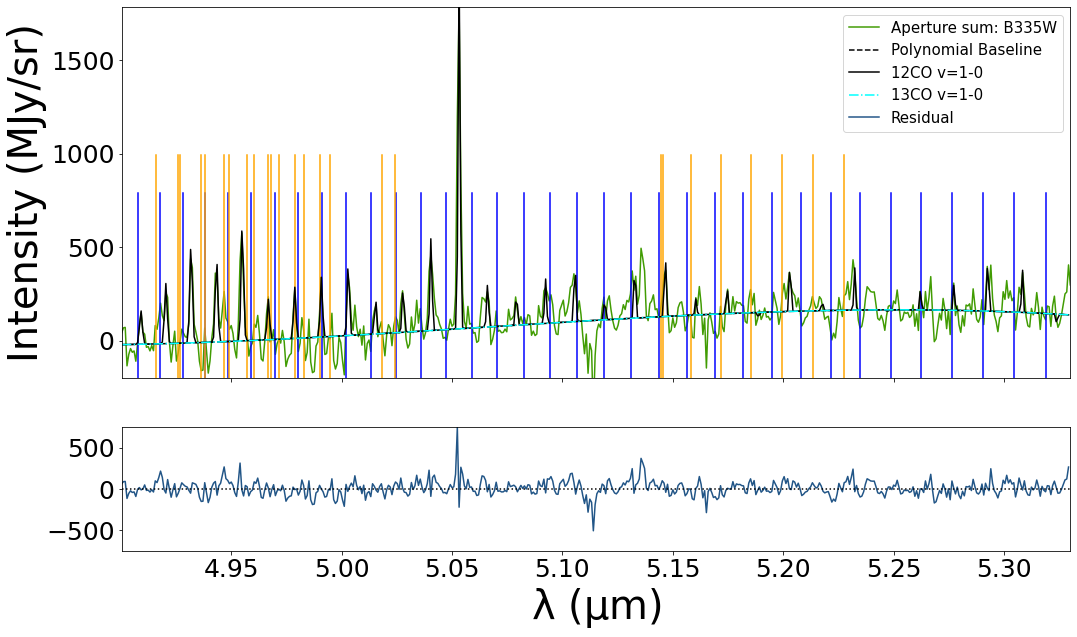

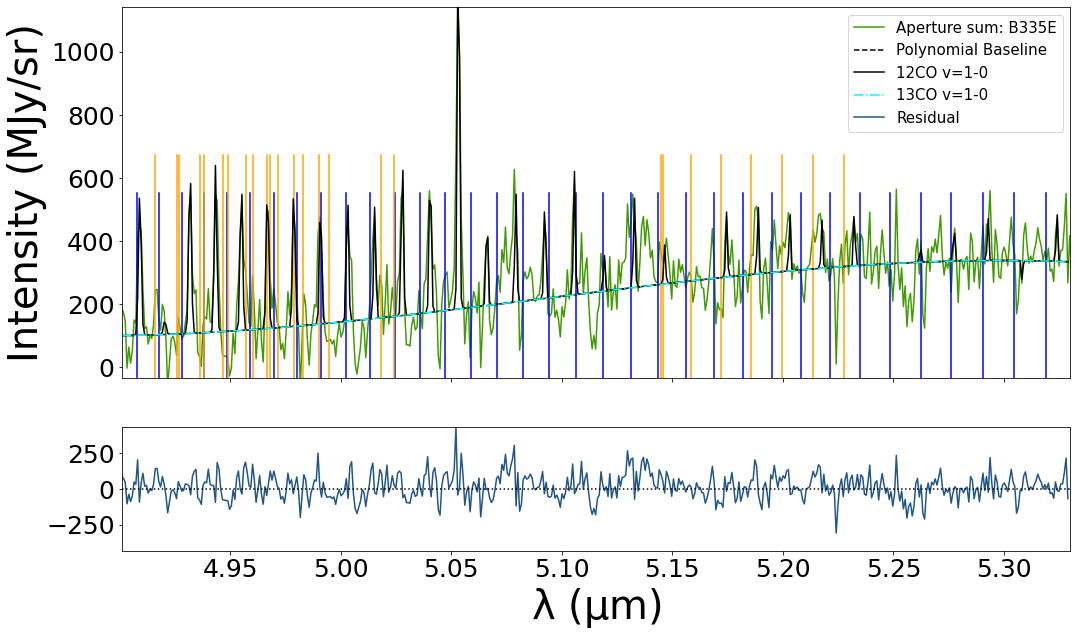

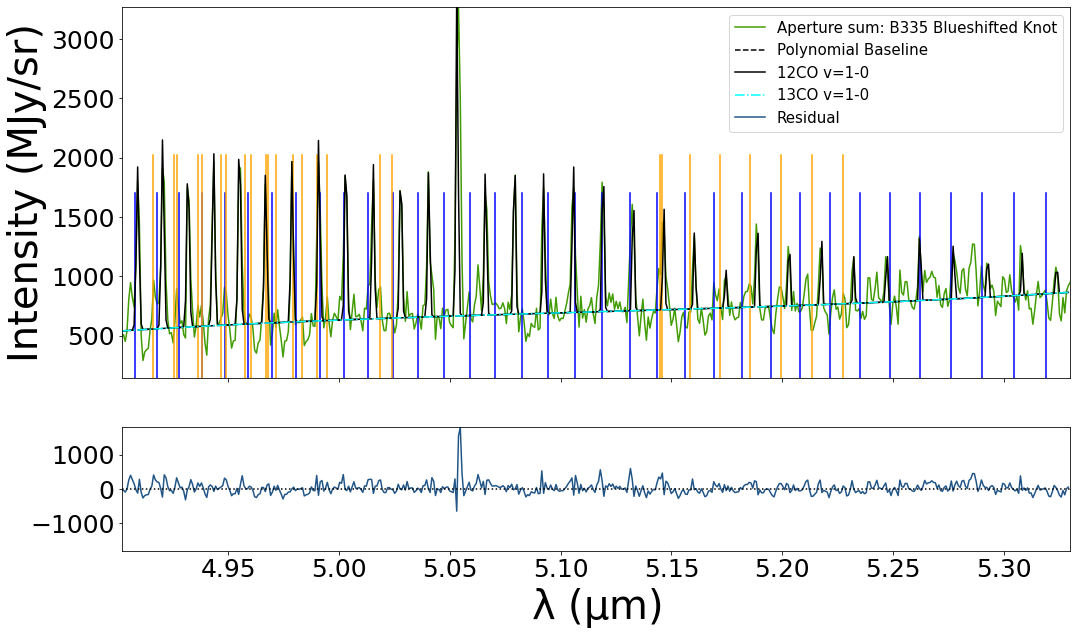

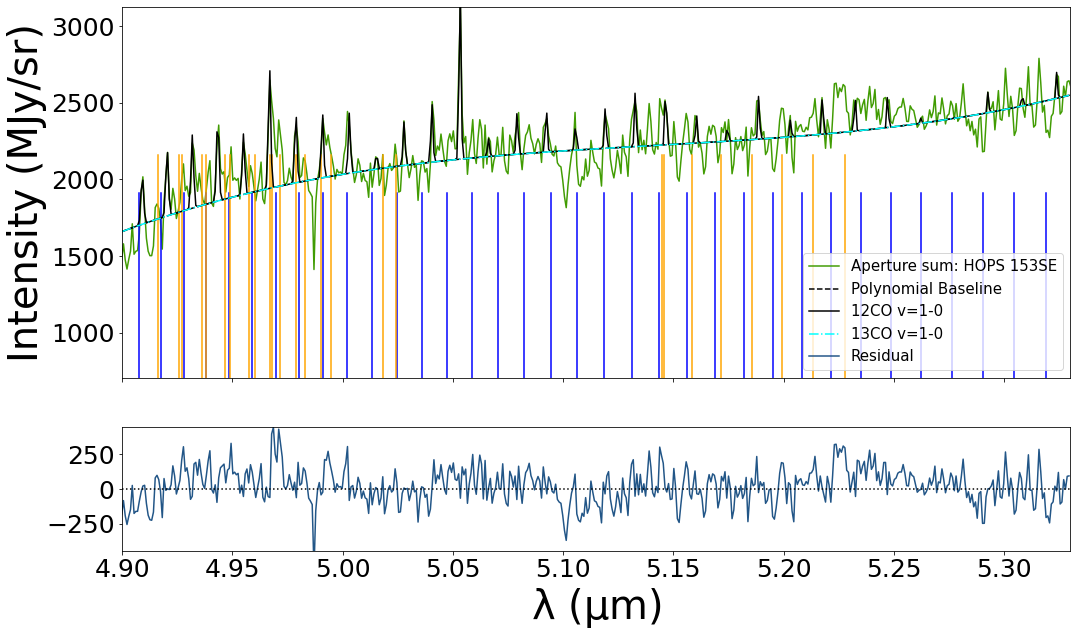

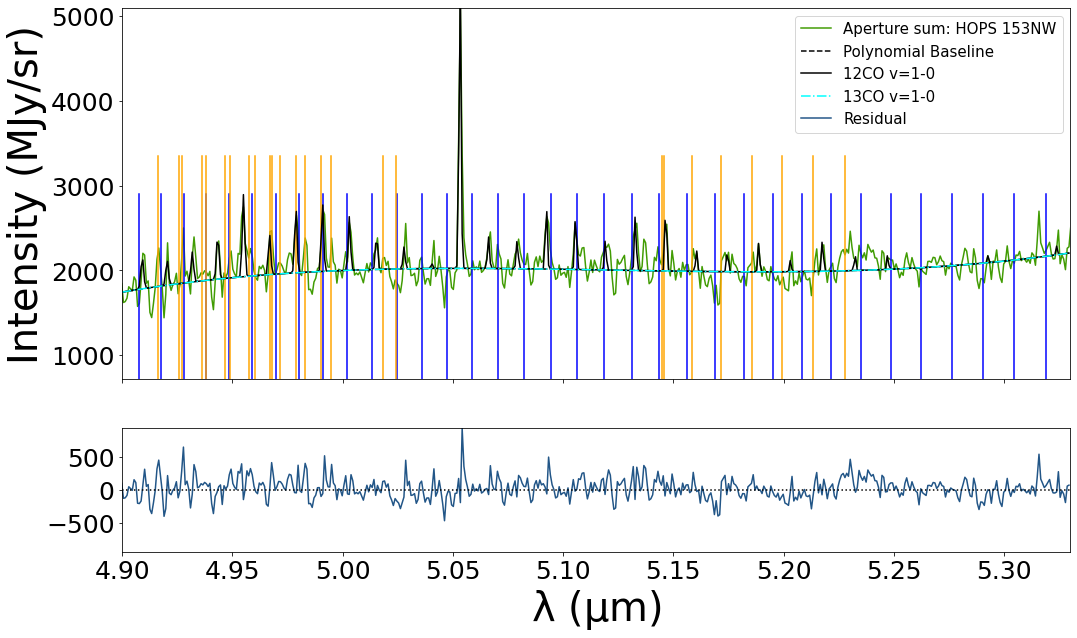

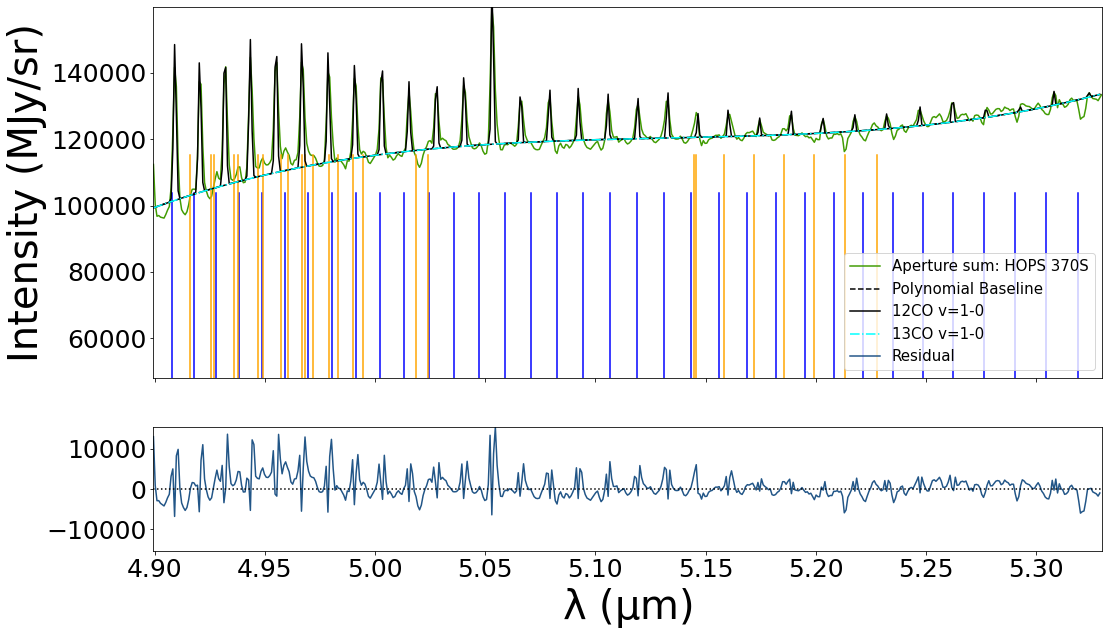

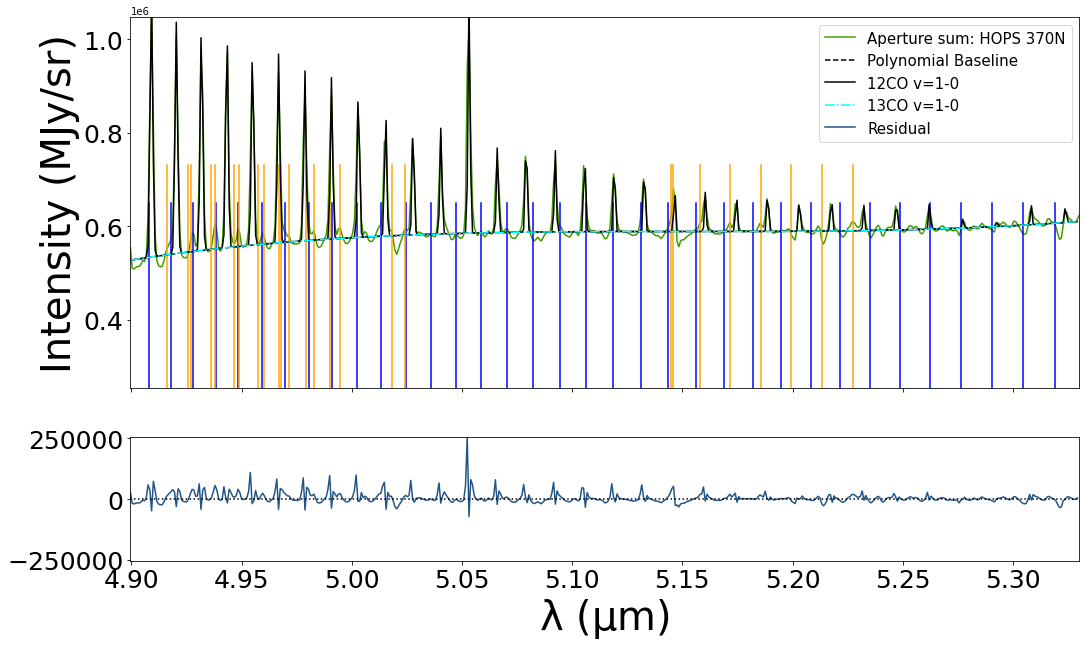

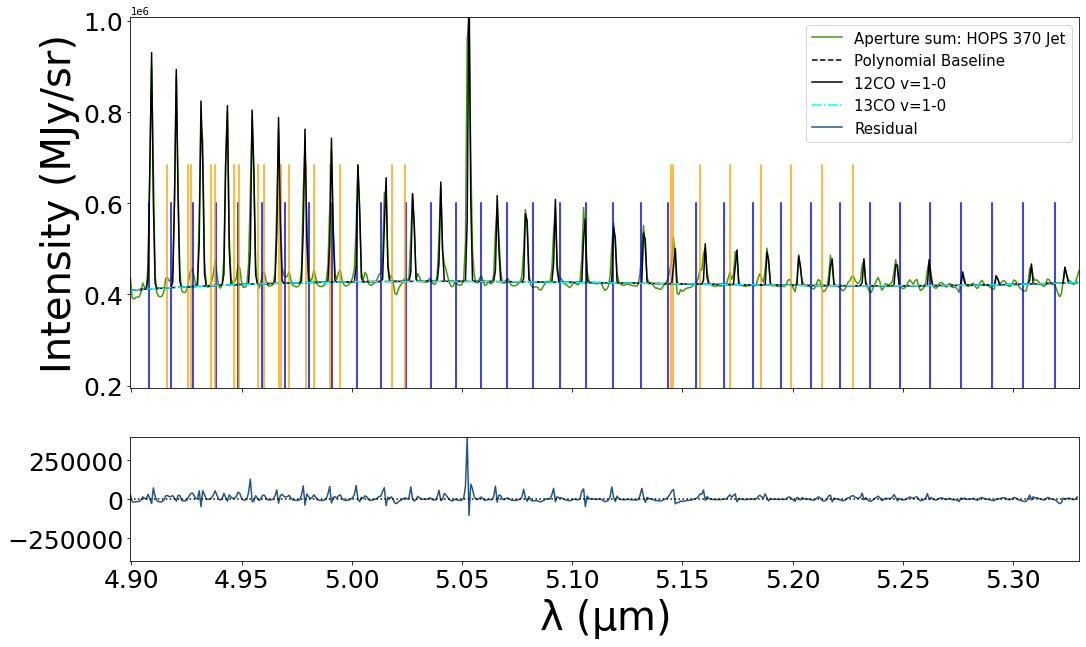

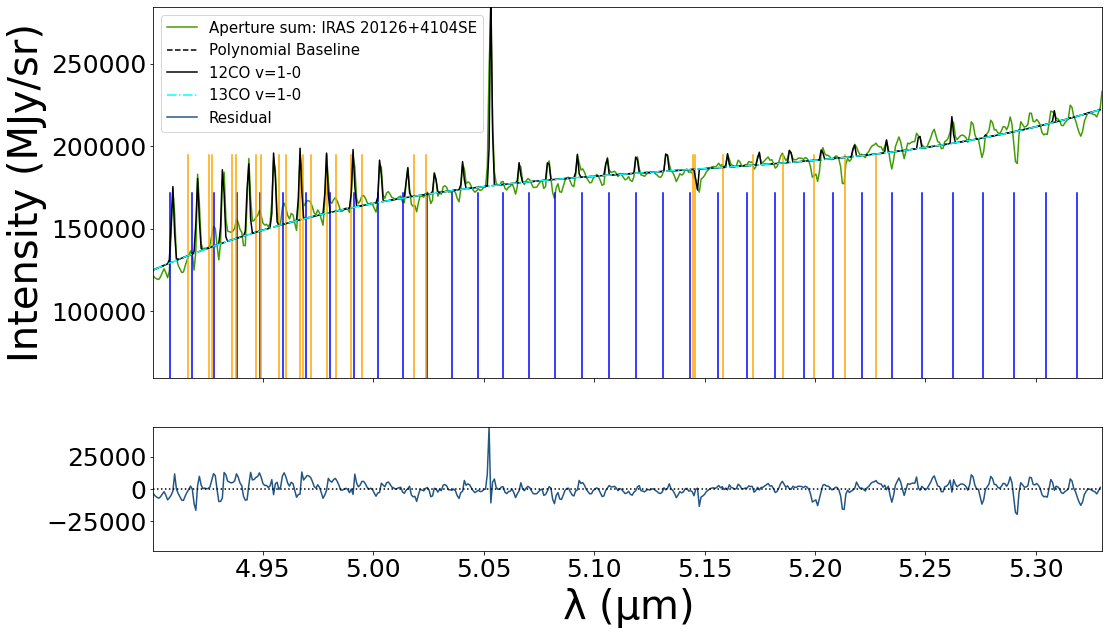

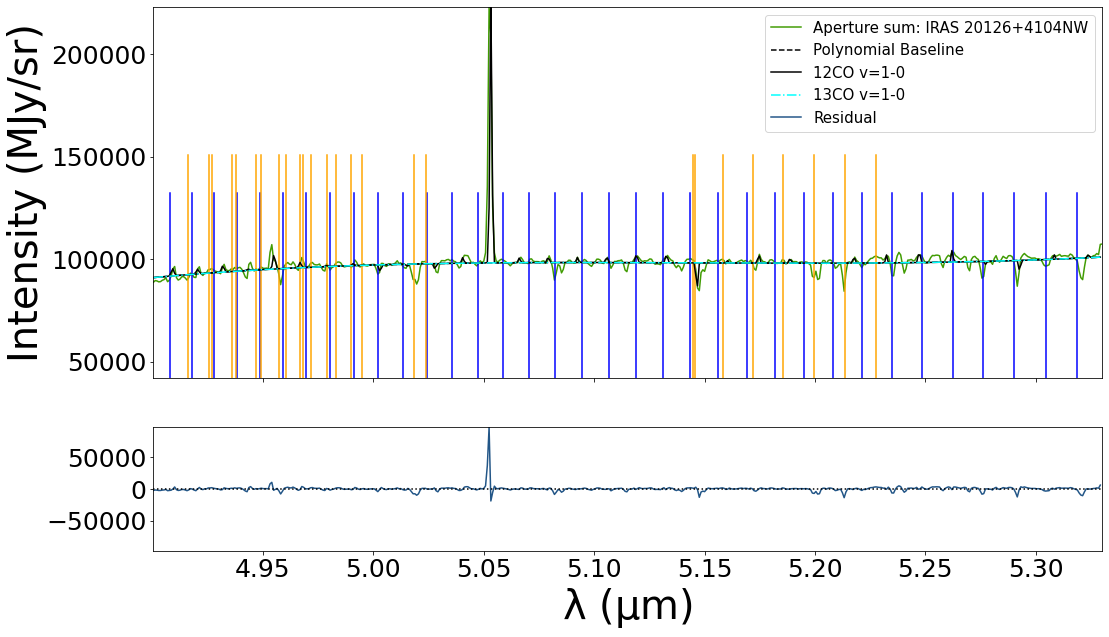

In [76]:
#finally, trying our fitting code
#next, we set up torch, guesses have to be done later in loop
#setting up generic functions to fit unresolved lines
#x is the full list of wavelengths, offset is the line's wavelength, and delta is the width of the gaussian
# import jax.numpy as jnp #need to swap this with numpy!

#testing torchimize instead: https://github.com/hahnec/torchimize
#thankfully the jacobian comes built in
from torchimize.functions import gradient_descent

#fitting line amplitudes
#note format of arrays is wavelength, x, y

# Let's try making a baseline image while looping through wavelengths
from pybaselines import Baseline, utils
# from scipy.signal import medfilt, savgol_filter
# from scipy.interpolate import UnivariateSpline

#params to smooth out data
from scipy.signal import argrelextrema #to break up lists
wave_offset_list = [[-3.75e-4], [0, 5e-4, 1.5e-3], [-6e-4, -6e-4], [-1e-3, -8e-4, -8e-4], [-1e-5,1e-5]] #1e-4
# wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939])
# smooth_list = [1, 1, 10, 1, 5, 3, 10, 10] #smoothing parameters for baseline #third to last originally 3
# alpha_list = [1, 100, 50, 100, 3, 100, 1, 1] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]
# N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
wave_max_val = 5.33

#13co lines?
#currently using P15 to P50
co_isotopologue_lines = [5.333388488, 5.318877235, 5.30451849, 5.29031078, 5.276252668, 5.26234273, 5.248579578, 5.234961839, 5.221488168, 5.208157241, 5.194967755, 5.181918437, \
    5.169008024, 5.15623528, 5.143598992, 5.131097968, 5.118731029, 5.106497024, 5.094394818, 5.082423295, 5.070581362, 5.058867934, 5.047281958, 5.035822391, \
    5.024488207, 5.013278402, 5.002191988, 4.991227989, 4.980385452, 4.969663437, 4.95906102, 4.948577297, 4.938211373, 4.927962373, 4.917829436, 4.907811716]
co_v2_or_3_lines = [4.916094136, 4.925723328, 4.926943518, 4.936135614, 4.93791873, 4.946671911, 4.949020785, 4.957333173, 4.960250699, 4.966840267, 4.968120359, 4.971609517, \
                    4.979034458, 4.983098297, 4.990076467, 4.994718123, 5.018355322, 5.023980249, \
                    5.144797803, 5.14575249, 5.158228694, 5.171807925, 5.185536908, 5.19941707, 5.213449873, 5.227636799]


#loop through, read in data files, extract data at single pixel, plot
for i in range(len(protostars)):
    # if i != 3:
    #     continue

    #read in original data
    hdul = fits.open(cube_file_list[i]) #separated out line here since need to use hdul a few times
    orig_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
    # err_data = hdul['ERR'].data[1:-1, int(central_sources[i][0]), int(central_sources[i][1]) ] #needed for chi^2...converting to torch 

    for k in range(len(source_names_list[i])):
        source = source_names_list[i][k] #define name using indices

        #before getting a slab with an aperture, we want to use the aperture to define a mask
        rect_aper = SkyRectangularAperture(sky_coord_list[i][k], aper_dims[i][0]*u.arcsec, aper_dims[i][1]*u.arcsec, theta=theta[i]*u.deg) #using sky coords
        wcs_header = WCS(orig_cube.header).dropaxis(2) #dropping the wavelength axis in this wcs to only account for spatial transformation
        rect_mask = rect_aper.to_pixel(wcs_header).to_mask() #converting to a spatial mask

        #extracting slab
        data_list = [] #dummy list
        for data_2d in orig_cube._data[:,:,:]: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        orig_slab = np.array(data_list) #need to invoke original cutoff...but as a slab this time

        # define the wavelength grid (microns) from the header
        wave = orig_cube.spectral_axis.value + wave_offset_list[i][k]
        wave_max_ind = np.argmin(np.abs(wave - wave_max_val))

        #plotting to compare the bright v=1 CO lines to the weak CO lines possible in the residuals (checking for overlaps with 13CO or non-overlaps with v>1)
        #do some averages and plot
        avg_orig_slab = np.nansum(orig_slab, axis=(1,2)) #could do median, but let's do sum

        #compute our fitted baseline of continuum+ices with a single baseline first with an initial tophat filter estimation
        # baseline_smoother = coeffs_list[-1][len(unres_wavelengths):len(unres_wavelengths)+len(smooth_list)]    
        # baseline_fitter_global = Baseline(wave[:wave_max_ind], check_finite=True) #generic preset the baseline object given a list of x-values (wavelengths)
        # bkg_top = baseline_fitter_global.tophat(avg_orig_slab[:wave_max_ind], half_window=5)[0]         #access cube to separate out an initial estimate for the baseline

        #first try, fitting with the preferred but complex method (jbcd)
        #we can also try a few other types, like polynomials and splines
        baseline_fitter_local = Baseline(wave[:wave_max_ind], check_finite=True)
        baseline = baseline_fitter_local.jbcd(avg_orig_slab[:wave_max_ind], half_window=3, alpha=0.12)[0] #this is the actual baseline fitting step
        # baseline_list = np.concatenate((baseline_list, baseline)) #concat to list
        baseline_poly = baseline_fitter_local.imodpoly(avg_orig_slab[:wave_max_ind], poly_order=3)[0] #this is the actual baseline fitting step        
        baseline_alt = baseline_fitter_local.asls(avg_orig_slab[:wave_max_ind], lam=1e5, p=0.12)[0] #this is the actual baseline fitting step        



        #reading in wavelength data
        unres_line_list = [pd.read_excel(line_list_path, sheet_name=unres_line_sheets[sheet]) #, skiprows=skiprow_list[i]) 
                        for sheet in range(len(unres_line_sheets))] #read in excel here, separate reads for each sheet is best
        unres_line_list = [unres_line for unres_line in unres_line_list[0]['Wv, microns'].values if unres_line > min(wave) and unres_line < wave[wave_max_ind]]
        unres_wavelengths = np.array(unres_line_list, dtype=np.float32)
        
        #defining indices in case we want to divide up species, vibrational transitions, etc
        #first locate extrema in the list, then we can index accordingly
        extreme_wavelengths = argrelextrema(unres_wavelengths, np.greater)
        wave_co_12_v10 = unres_wavelengths[0:extreme_wavelengths[0][0]+1]
        wave_co_12_v21 = unres_wavelengths[extreme_wavelengths[0][0]+1 : extreme_wavelengths[0][1]]
        wave_co_12_v32 = unres_wavelengths[extreme_wavelengths[0][1]+1 : extreme_wavelengths[0][2]]
        wave_co_13_v10 = unres_wavelengths[extreme_wavelengths[0][2]+1:]
        fitting_wavleengths = np.concatenate((wave_co_12_v10, wave_co_13_v10))

        #write out most of the possible useful lists for our case
        # CO_wavelengths = unres_line_list[0]['Wv, microns'].to_numpy()
        # CO_species = unres_line_list[0]['Species'] + ' v=' + unres_line_list[2]['Transition, v']  + ' ' + unres_line_list[2]['Transition, J']
        # CO_species = CO_species.to_numpy() #for CO

        #and making some connected lists of species and wavelengths (useful for referencing)
        # line_wave_list = unres_wavelengths
        # species_list = list(itertools.chain([re.sub(" ","", i) for i in ion_species], hydrogen_species, CO_species))

        #this part needs to be done AFTER checking all the lines and wavelengths we're using...
        #computing exponential part of gaussian to speed things up (see other scripts if more intuitive)
        R = jwst_res_dmw(torch.tensor(wave[:wave_max_ind], dtype=torch.float)) #mode for NIRSpec has R ~ 1000 ~ lambda / FWHM
        FWHM = torch.tensor(wave[:wave_max_ind], dtype=torch.float) / R  #this is delta lambda
        sigma = FWHM / np.sqrt(8.0*np.log(2.0)) #property of gaussians
        sigma_sq = sigma*sigma #pre-calculating sigma^2
        unres_exp = torch.stack([torch.exp(-torch.pow(torch.tensor(wave[:wave_max_ind], dtype=torch.float) - unres_wave, 2) / (2 * sigma_sq)).float() for unres_wave in fitting_wavleengths], dim=0)



        #onto guesses
        amp_guesses = torch.rand(len(fitting_wavleengths), dtype=torch.float) #converted to torch
        amp_guesses[:len(fitting_wavleengths)] = 100

        ###BEGIN FITTING CODE HERE!
        baseline_subtracted_spectrum = torch.from_numpy(np.array(avg_orig_slab[:wave_max_ind] - baseline_poly, dtype=np.float32))                #baseline subtraction
        stacked_coeffs = torch.from_numpy(np.zeros(len(amp_guesses))).float()
        coeffs_list = gradient_descent(amp_guesses.float(), function=residual_spectrum_fit, args=(baseline_subtracted_spectrum,unres_exp), ftol=1e-5, gtol=1e-5, ptol=1e-5, l=1.0) #fit lines for cube
        stacked_coeffs = coeffs_list[-1].float()

        #if we want applying a quick redistribution for the H2 line...do it here...

        #breaking up fit amplitudes into different regimes
        fitted_co_12_v10 = torch.einsum('i,il->l', stacked_coeffs.float()[0:extreme_wavelengths[0][0]+1], unres_exp.float()[0:extreme_wavelengths[0][0]+1]).float()  
        # fitted_co_12_v21 = torch.einsum('i,il->l', stacked_coeffs.float()[extreme_wavelengths[0][0]+1 : extreme_wavelengths[0][1]], unres_exp.float()[extreme_wavelengths[0][0]+1 : extreme_wavelengths[0][1]]).float()  
        # fitted_co_12_v32 = torch.einsum('i,il->l', stacked_coeffs.float()[extreme_wavelengths[0][1]+1 : extreme_wavelengths[0][2]], unres_exp.float()[extreme_wavelengths[0][1]+1 : extreme_wavelengths[0][2]]).float()  
        fitted_co_13_v10 = torch.einsum('i,il->l', stacked_coeffs.float()[extreme_wavelengths[0][2]+1:], unres_exp.float()[extreme_wavelengths[0][2]+1:]).float()  

        #reapplying fit
        # unres_fit = torch.einsum('i,il->l', stacked_coeffs.float(), unres_exp.float()).float()
        total_fit = fitted_co_12_v10 + fitted_co_13_v10 + baseline_poly # + fitted_co_12_v32 + fitted_co_12_v21

        #plotting
        fig, (ax, ax_resid) = plt.subplots(nrows=2, ncols=1, figsize=(17,10), sharex=True, gridspec_kw={'height_ratios': [3, 1]}) #setup fig, axes
        ax.plot(wave, avg_orig_slab, color='xkcd:grassy green', label='Aperture ' + average + ': ' + source) #plotting curves
        
        # ax.axvline(5.33004917, 0.5, 1, color='blue', linestyle='-', label=r'$\rm H_2 \ 1-1 \ S8$')
        # ax.axvline(5.511183183, 0, 0.08, color='blue', linestyle=':', label=r'$\rm [Fe II]$')
        # ax.axvline(5.053115061, 0, 0.08, color='red', linestyle='--', label=r'$\rm H_2 \ S8$') #marking H2
        vlines_isotopologues = [ax.axvline(isotopologue_wave, ymin=0., ymax=0.5, color='blue') for isotopologue_wave in co_isotopologue_lines]
        vlines_highorder = [ax.axvline(isotopologue_wave, ymin=0, ymax=0.6, color='orange') for isotopologue_wave in co_v2_or_3_lines]

        # ax.plot(wave[:wave_max_ind], bkg_top, color='black', linestyle='--', label='Top-Hat Filter')
        # ax.plot(wave[:wave_max_ind], baseline, color='xkcd:black', linestyle='--', label='NIRSpec Methods (jcbd)') #marking some different baselines
        ax.plot(wave[:wave_max_ind], baseline_poly, color='xkcd:black', linestyle='--', label='Polynomial Baseline')
        # ax.plot(wave[:wave_max_ind], baseline_alt, color='xkcd:black', linestyle='--', label='Asymmetric Least Squares')

        # ax.plot(wave[:wave_max_ind], total_fit, color='goldenrod', linestyle='--', label='Total Fit') #marking a fit 
        ax.plot(wave[:wave_max_ind], fitted_co_12_v10 + baseline_poly, color='black', linestyle='-', label='12CO v=1-0') #marking a fit 
        # ax.plot(wave[:wave_max_ind], fitted_co_12_v21 + baseline_poly, color='goldenrod', linestyle='--', label='12CO v=2-1') #marking a fit 
        # ax.plot(wave[:wave_max_ind], fitted_co_12_v32 + baseline_poly, color='xkcd:purple', linestyle=':', label='12CO v=3-2') #marking a fit 
        ax.plot(wave[:wave_max_ind], fitted_co_13_v10 + baseline_poly, color='xkcd:cyan', linestyle='-.', label='13CO v=1-0') #marking a fit 
        # ax.plot(wave, avg_v2_slab, color='xkcd:orange', linestyle='-.', label='Residual Fit')
        # ax.plot(wave, orig_data - total_fit - (gas_line_V2_fit - gas_line_fit), color='xkcd:twilight blue', label='Residual (Second Fit)', alpha=0.9)
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        # ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40) #need to set the xlabel here first
        ax.set_xlim(min(wave), wave_max_val)
        ax.set_ylim(np.min(avg_orig_slab[:wave_max_ind])/2, np.max(avg_orig_slab[:wave_max_ind])*1)
        # ax.set_yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=25)

        #add to this a residual plot
        # ax_resid.plot(wave, gas_line_fit, color='xkcd:grassy green', label='Fitted Gas Lines')
        ax_resid.plot(wave[:wave_max_ind], avg_orig_slab[:wave_max_ind] - total_fit.numpy(), color='xkcd:twilight blue', label='Residual', alpha=0.9)
        ax_resid.axhline(0, color='k', linestyle=':') #a horizontal line at zero
        ax_resid.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40) #need to set the xlabel here first
        ax_resid.tick_params(axis='both', which='major', labelsize=25)
        ax_resid.set_ylim(-1e0*np.max(avg_orig_slab[:wave_max_ind] - total_fit.numpy()), 1e0*np.max(avg_orig_slab[:wave_max_ind] - total_fit.numpy()))
        
        #general formatting plot
        handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax_resid.get_legend_handles_labels())] #https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots
        ax.legend(handles, labels, loc='best', fontsize=15)
        # ax.set_xticks(np.arange(min(wave), 5.25, 0.25))
        fig.savefig('CO_MIRI/' + source + '_' + average + '_spectra.pdf') #save plot
        
        # sys.exit()
        
# import time
# t0 = time.time()
# t1 = time.time()

# print('start: ', t0, ', end: ', t1, ', diff: ', t1-t0)

In [62]:
#B335 blueshift...
delta_lam_b335 = 1.0 / 1500 # 1.5e-3 - 5e-4 
print(delta_lam_b335, 3e5 * delta_lam_b335)

0.0006666666666666666 200.0
